In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from ipywidgets import IntProgress
from IPython.display import display, HTML

import base
import fund_scanner.common_tools.database as db
engine = db.get_sqlalchemy_engine(dbname='stock_index')

import logging
import fund_scanner.common_tools.logger as logger
log = logging.getLogger('view_indexes')


In [2]:
df = pd.read_sql('select * from stock_indexes where `发布日期` between "2017-08-05" and Now();', engine)
df_to_plot = pd.DataFrame([])
for code in df['index_code'].unique():
    df_one_kind = df.loc[df['index_code']==code, ['序号','行业','行业指数','涨跌幅','发布日期','index_code']]
    df_one_kind = df_one_kind.reset_index().set_index('发布日期')
    
    industry_name = df_one_kind['行业'].iloc[0]
    first_number = df_one_kind['行业指数'].iloc[0]
    df_to_plot[industry_name] = df_one_kind['行业指数'] / first_number * 100

df_to_plot = df_to_plot.sort_values(by=df_to_plot.last_valid_index(), axis=1, ascending=False)

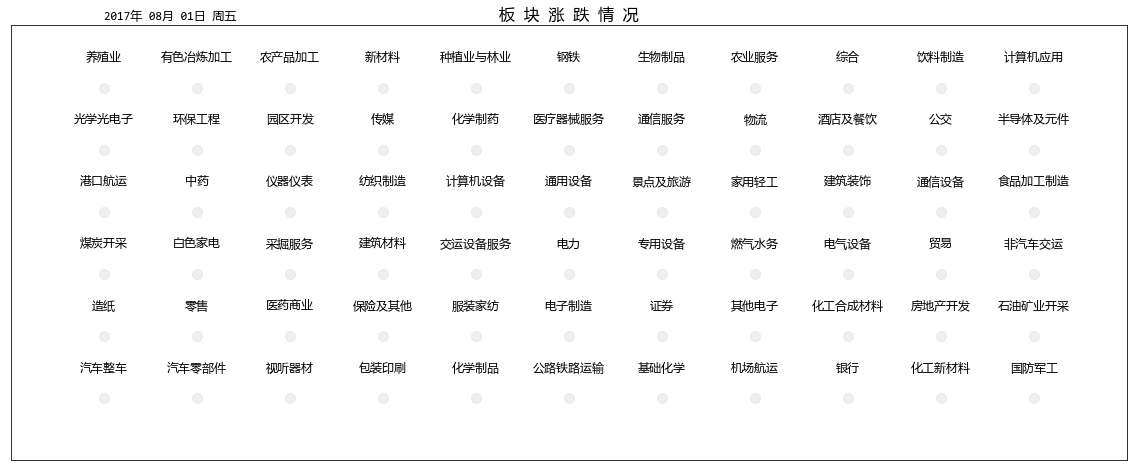

In [3]:
lst_industry_names = df_to_plot.columns.tolist()


items_each_row = 11
bubble_size_max = 1e4
bubble_size_middle = 1e2
bubble_size_min = 10
subtitle_offset_x = 0
subtitle_offset_y = -0.5

fig = plt.figure(figsize=[20,8])
ax = fig.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, items_each_row+1)
ax.set_ylim(len(lst_industry_names) // items_each_row + 1, 0)

ax.set_title(u'板 块 涨 跌 情 况', fontsize=16)
element_date = ax.text(1,-0.1,u'2017年 08月 01日 周五', fontsize=12)

i=0
element_scat = []
element_text = []
for industry_name in lst_industry_names:
    pos_x = i % items_each_row + 1
    pos_y = i // items_each_row + 1
    scat = ax.scatter(pos_x, pos_y, s=bubble_size_middle, facecolor=(0.8,0.8,0.8,1), alpha=0.3)
    text = ax.text(pos_x+subtitle_offset_x, pos_y+subtitle_offset_y, industry_name, fontsize=12, horizontalalignment='center', verticalalignment='center')
    element_scat.append(scat)
    element_text.append(text)
    i=i+1



In [6]:
frames_per_day = 10
g_max = df_to_plot.max().max()
g_min = df_to_plot.min().min()
target_size = [bubble_size_middle] * len(element_scat)
last_size = [bubble_size_middle] * len(element_scat)

progress = IntProgress(min=0, max=(len(df_to_plot)+1)*frames_per_day-1, value=0)
display(progress)

def update(frame):
    global target_size, last_size, progress, frames_per_day, df_to_plot
    global element_date, element_scat, element_text
    progress.value = frame
    if progress.max <= frame:
        progress.bar_style = 'success'
    row = frame // frames_per_day
    last = frame % frames_per_day
    #print(row, last, len(df_to_plot))
    if (row<len(df_to_plot)):
        for idx, scat in enumerate(element_scat):
            if last==0:
                element_date.set_text(df_to_plot.iloc[row].name.strftime('%Y年 %m月 %d日 星期%w'))
                last_size[idx] = target_size[idx]
                val = df_to_plot.iloc[row, idx]
                target_size[idx] = (val - g_min) * (bubble_size_max-bubble_size_min) / (g_max - g_min) + bubble_size_min
                if target_size[idx]>last_size[idx]:
                    scat.set_facecolors(['red'])
                elif target_size[idx]<last_size[idx]:
                    scat.set_facecolors(['green'])
                else:
                    scat.set_facecolors([(0.8,0.8,0.8,1)])
                #if (idx==1):
                    #print('last_size:',last_size[idx],'target_size:',target_size[idx])
            size = (target_size[idx] - last_size[idx]) * last / frames_per_day + last_size[idx]
            
            scat.set_sizes([size])
        return element_scat
    return

animation = FuncAnimation(fig, update, interval=100, blit=False, frames=(len(df_to_plot)+1)*frames_per_day)
display(HTML(animation.to_html5_video()))
progress.close()


In [5]:
print(df_to_plot.min().min())
print(df_to_plot.max().max())

df_to_plot.iloc[0].name.strftime('%Y-%m-%d')

98.764685675
105.378919132


'2017-08-05'